In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5658339.datarmor0/parcels-502090/libparcels_random_5413276e-9599-4333-9f7b-087347f956ea.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=8
                 )
#
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://10.148.0.89:46874 Dashboard: http://10.148.0.89:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Using indices : 

In [6]:
# All faces
grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')

depth = grid.Depth.isel(i=slice(0,None,4), j=slice(0,None,4))
depth = depth.where(depth>0)

#(depth
# .plot(col='face', col_wrap=5)
#)

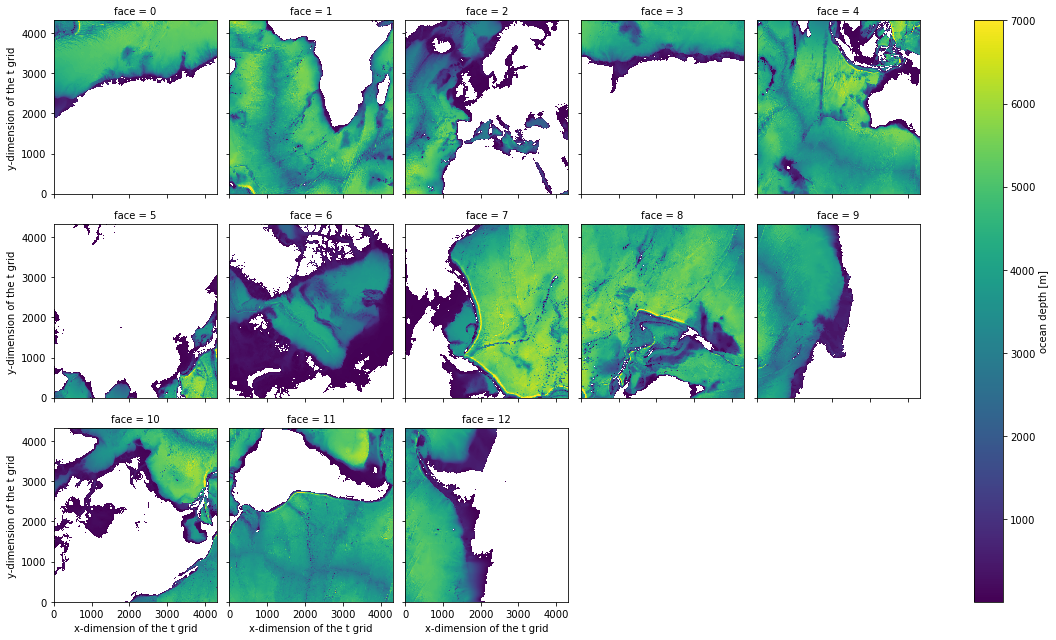

In [5]:
(depth
 .plot(col='face', col_wrap=5)
)

In [55]:
#isel = dict(face=10)
#sel = dict(i=slice(2500,3500),j=slice(0,1000),i_g = slice(2500,3500),j_g=slice(0,1000))
#, i=slice(2500, 3500), j=slice(0, 1000), i_g=slice(2500, 3500), j_g=slice(0, 1000)) # California
#isel = dict(face=2)
#sel = dict(i=slice(1500, 2200),j=slice(1000, 2000),i_g = slice(1500, 2200),j_g=slice(1000, 2000))
#isel = dict(face=2, i=slice(1500, 2200), j=slice(1000, 2000), i_g=slice(1500, 2200), j_g=slice(1000, 2000)) # Mediterranean sea
isel = dict(face=4)
sel = dict(i=slice(3000, 4000), j=slice(2000, 3000), i_g=slice(3000, 4000), j_g=slice(2000, 3000)) # North West Australia

In [56]:
V = ['SSU', 'SSV']
#V = ['SST', 'SSS']

ds = ut.load_data(V)
ds = ds.isel(**isel).sel(**sel)
grd = grid.isel(**isel).sel(**sel)
ds = xr.merge([ds, grd])

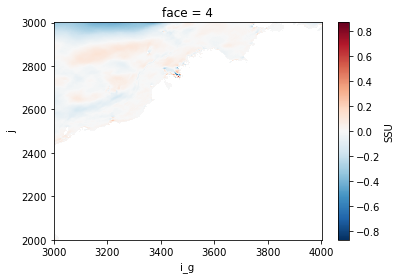

In [57]:
ds.SSU.mean('time').plot()

In [58]:
#sli = 4
#ds = ds.isel(i = slice(0,None,sli), j = slice(0,None,sli), i_g = slice(0,None,sli), j_g = slice(0,None,sli))
ds['lon'] = 0*ds.face+ds.XC
ds['lat'] = 0*ds.face+ds.YC

In [59]:
#bbox = [-130, -118, 30, 40] # california
#bbox = [-2, 8, 36, 45] # mediterranean sea
bbox = [120, 126, -20, -10] # North-west Australia

ds = ds.drop(['i_g','j_g']).rename({'i_g':'i','j_g':'j'})#.drop(['i_g','j_g'])

In [60]:
ds['zonal_velocity'] = ds['SSU']*ds.CS - ds['SSV']*ds.SN
ds['meridional_velocity'] =  ds['SSU']*ds.SN + ds['SSV']*ds.CS

In [61]:
ds = ds.drop(['SSU','SSV'])

In [62]:
ds_sub = ds.where((ds.lat<=bbox[3]) & (ds.lat>=bbox[2]),drop=True).persist()#& (ds.lon>=bbox[0])& (ds.lon<=bbox[1])).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  r

In [63]:
ds_sub = ds_sub.where((ds_sub.lon>=bbox[0])& (ds_sub.lon<=bbox[1]),drop=True).persist()#& (ds.lon>=bbox[0])& (ds.lon<=bbox[1])).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  r

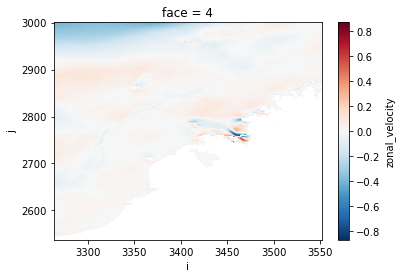

In [64]:
ds_sub.zonal_velocity.mean('time').plot()

In [65]:
ds_sub = ds_sub.drop(['CS','SN','XC','XG','YC','YG','dxC',
                      'dxG','dyC','dyG','rA','rAs','rAw','rAz'])
ds_sub#

<xarray.Dataset>
Dimensions:              (i: 288, j: 463, time: 8785)
Coordinates:
    face                 int64 4
  * j                    (j) int64 2538 2539 2540 2541 ... 2997 2998 2999 3000
    niter                (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time                 (time) datetime64[ns] 2011-11-15 ... 2012-11-15
  * i                    (i) int64 3264 3265 3266 3267 ... 3548 3549 3550 3551
    Depth                (j, i) float32 dask.array<chunksize=(463, 288), meta=np.ndarray>
Data variables:
    lon                  (j, i) float64 dask.array<chunksize=(463, 288), meta=np.ndarray>
    lat                  (j, i) float64 dask.array<chunksize=(463, 288), meta=np.ndarray>
    zonal_velocity       (time, j, i) float32 dask.array<chunksize=(1, 463, 288), meta=np.ndarray>
    meridional_velocity  (time, j, i) float32 dask.array<chunksize=(1, 463, 288), meta=np.ndarray>

In [66]:
# define target chunks
chunks_new = dict(time=1024, i=128, j=128) # 512, 256, 256 may have been a better choice
#chunks_new["i_g"] = chunks_new["i"]
#chunks_new["j_g"] = chunks_new["j"]

ds_sub = ds_sub.chunk(chunks_new)

In [67]:
import os
out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_nwa")
llc_zarr = os.path.join(out_dir, "llc.zarr")




In [68]:
ds_sub.to_zarr(llc_zarr, mode="w")

#### Lagrangian data

In [48]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
parcels_index = 'time_mean'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]

df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,Eta_interp,SSU_interp,SST_interp,SSV_interp,SSS_interp
time,,,,,,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0,0.060997,-0.002461,4.279537,-0.006017,33.194778
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0,0.075155,-0.091730,4.326020,0.050204,33.139637
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0,0.169278,-0.203138,4.161501,0.209887,32.961617
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0,0.242839,-0.075768,3.679666,0.064889,32.712219
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0,0.222071,-0.006189,3.151162,0.057710,32.573410


In [69]:
import os
out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_nwa")
#llc_zarr = os.path.(out_dir, "llc.zarr")


In [70]:
#bbox = [-130, -118, 30, 40] # california
#bbox = [-2, 8, 36, 45] # mediterranean sea
bbox = [120, 126, -20, -10] # North-west Australia

parcels_name = "llc_parcels_"+parcels_index
parcels_path = os.path.join(out_dir, parcels_name)

In [71]:
# extract relevant trajectory indices
_df = df[ (df.lon>=bbox[0])
        &(df.lon<=bbox[1])
        &(df.lat>=bbox[2])
        &(df.lat<=bbox[3])
       ]
traj = _df.drop_duplicates(subset=["trajectory"]).compute()["trajectory"]
df_selected = df[df.trajectory.isin(traj)]

In [72]:
lon,lat = df_selected.lon.values.compute(),df_selected.lat.values.compute()

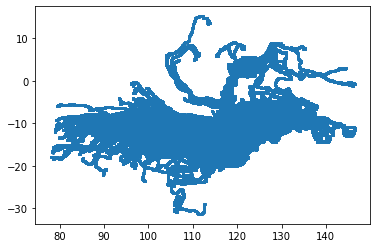

In [73]:
plt.scatter(lon,lat,s=4)

In [74]:
pa.store_parquet(out_dir, df_selected, name=parcels_name, overwrite=True)

No reindexing
deleting existing archive: /home/datawork-lops-osi/equinox/mit4320/diags/regional_nwa/llc_parcels_time_mean
create new archive: /home/datawork-lops-osi/equinox/mit4320/diags/regional_nwa/llc_parcels_time_mean


'/home/datawork-lops-osi/equinox/mit4320/diags/regional_nwa/llc_parcels_time_mean'

### Load data

In [75]:
import os
out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_nwa")
llc_zarr = os.path.join(out_dir, "llc.zarr")
ds = xr.open_zarr(llc_zarr)

In [76]:
ds_mean = ds.mean('time').compute()

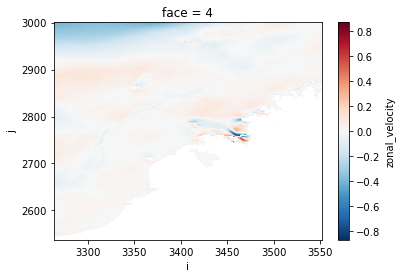

In [77]:
ds_mean.zonal_velocity.plot()

In [78]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
